In [92]:
#modified from http://programmingcomputervision.com/downloads/ProgrammingComputerVision_CCdraft.pdf

from numpy import *
import cv2


# some constants and default parameters
lk_params = dict(winSize=(15,15),maxLevel=2,
                criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,10,0.03)) 

subpix_params = dict(zeroZone=(-1,-1),winSize=(10,10),
                     criteria = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS,20,0.03))

feature_params = dict(maxCorners=300,qualityLevel=0.1,minDistance=10)


class LKTracker(object):
    """    Class for Lucas-Kanade tracking with 
        pyramidal optical flow."""

    def __init__(self,images):
        """    Initialize with a list of image names. """

        self.images = images
        self.features = []
        self.tracks = []
        self.current_frame = 0

    def step(self,framenbr=None):
        """    Step to another frame. If no argument is 
            given, step to the next frame. """

        if framenbr is None:
            self.current_frame = (self.current_frame + 1) % len(self.images)
        else:
            self.current_frame = framenbr % len(self.images)

    def detect_points(self):
        """Detect 'good features to track' (corners) in the current frame
            using sub-pixel accuracy. """

        # load the image and create grayscale
        self.image = self.images[self.current_frame]
        self.gray = cv2.cvtColor(self.image,cv2.COLOR_BGR2GRAY)

        # search for good points
        features = cv2.goodFeaturesToTrack(self.gray, **feature_params)

        # refine the corner locations
        cv2.cornerSubPix(self.gray,features, **subpix_params)
        
        self.features = features
        self.tracks = [[p] for p in features.reshape((-1,2))]
        
        self.prev_gray = self.gray

    def track_points(self):
        """    Track the detected features. """

        if self.features != []:
            self.step() # move to the next frame
            
            # load the image and create grayscale
            self.image = self.images[self.current_frame]
            self.gray = cv2.cvtColor(self.image,cv2.COLOR_BGR2GRAY)
            
            # reshape to fit input format
            tmp = float32(self.features).reshape(-1, 1, 2)
            
            # calculate optical flow
            features,status,track_error = cv2.calcOpticalFlowPyrLK(self.prev_gray,self.gray,tmp,None,**lk_params)

            # remove points lost
            self.features = [p for (st,p) in zip(status,features) if st]
            
            # clean tracks from lost points
            features = array(features).reshape((-1,2))
            for i,f in enumerate(features):
                self.tracks[i].append(f)
            ndx = [i for (i,st) in enumerate(status) if not st]
            ndx.reverse() #remove from back
            for i in ndx:
                self.tracks.pop(i)
            
            self.prev_gray = self.gray
            
    def track(self):
        """    Generator for stepping through a sequence."""

        for i in range(len(self.images)):
            if self.features == []:
                self.detect_points()
            else:
                self.track_points()
            
            # create a copy in RGB
            f = array(self.features).reshape(-1,2)
            im = cv2.cvtColor(self.image,cv2.COLOR_BGR2RGB)
            yield im,f

    def draw(self):
        """    Draw the current image with points using
            OpenCV's own drawing functions. 
            Press ant key to close window."""

        # draw points as green circles
        for point in self.features:
            cv2.circle(self.image,(int(point[0][0]),int(point[0][1])),3,(0,255,0),-1)
        
        cv2.imshow('LKtrack',self.image)
        cv2.waitKey()

In [111]:
import warnings
warnings.filterwarnings("ignore")

from pylab import *
def totalMovement(filename):
    vidcap = cv2.VideoCapture('/Users/ethknig/'+filename)
    frames = []
    count = 0;
    success=True
    while success:
        success,image = vidcap.read(1)
        frames.append(image)
        if cv2.waitKey(10) == 27:    # exit if Escape is hit
            break
        count += 1
    print("Finished processing frames")
    print(str(len(frames))+" frames")
    frameConst=1
    printFeatures = True
    lkt = LKTracker(frames)
    frameIndex = 0
    for frame in frames:
        frameTracker = LKTracker([frame])
        try:
            list(frameTracker.track())
        except:
            pass
    try:
        lkt = LKTracker(frames)

        for im,ft in lkt.track():
            pass
        print("tracking %d features" % len(ft))
        # plot the tracks
    except:
        print("Got error! Trying every second frame")
        frameConst=2
        try:
            lkt = LKTracker(frames[::2])
            for im, ft in lkt.track():
                pass
            print("tracking %d features" % len(ft))
        except:
            try:
                frameConst=3
                print("Got error! Trying every third frame")
                lkt = LKTracker(frames[::3])
                for im, ft in lkt.track():
                    pass
                print("tracking %d features" % len(ft))
            except:
                frameConst=5
                print("Got error! Trying every fifth frame")
                lkt = LKTracker(frames[::5])
                for im, ft in lkt.track():
                    pass
                print("tracking %d features" % len(ft))
    figure()
    imshow(im)
    for p in ft:
        plot(p[0],p[1],'bx')
    for t in lkt.tracks:
        plot([p[0] for p in t],[p[1] for p in t])
    axis('off')
    show()
    totalList=[]
    for t in lkt.tracks:
        a=[p[0] for p in t]
        b=[p[1] for p in t]
        totalList.append(sqrt((a[0]-b[0])**2+(a[1]-b[1])**2))
    totalList=sort(totalList)[(len(totalList))//4:(3*len(totalList))//4] #iqr
    return (sum(totalList))/(count*frameConst) #movement per frame

Finished processing frames
289 frames
Got error! Trying every second frame
Got error! Trying every third frame
Got error! Trying every fifth frame
tracking 299 features


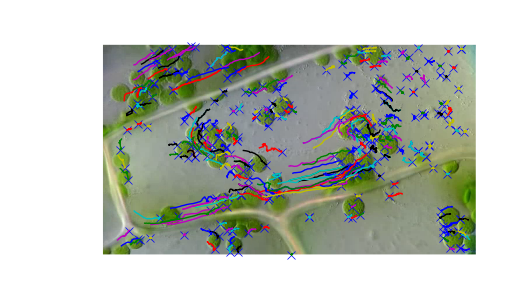

28.046481876453033

In [112]:
totalMovement("elodea.mp4") #slowest

Finished processing frames
85 frames
Got error! Trying every second frame
Got error! Trying every third frame
Got error! Trying every fifth frame
tracking 189 features


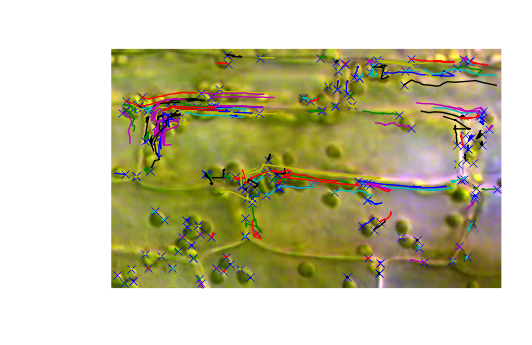

57.421023358863515

In [95]:
totalMovement("fast.mp4") #medium

Finished processing frames
525 frames
Got error! Trying every second frame
Got error! Trying every third frame
tracking 100 features


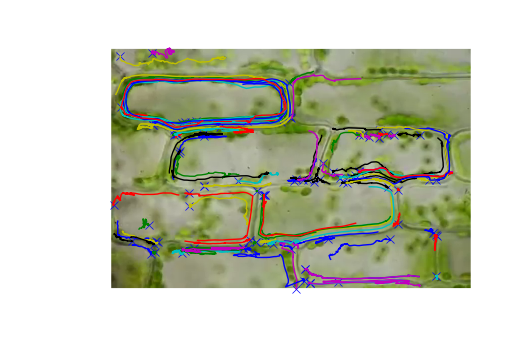

7.1002250212354934

In [96]:
totalMovement("eh.mp4") #fast